In [1]:
# SHAPE data for RNaseP
#
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from mpl_toolkits import mplot3d
from scipy.special import logsumexp
import time

shape_file_u = "data/RNASEP_DMS_0000.rdat.outu"
shape_file_p = "data/RNASEP_DMS_0000.rdat.outp"

datau = pd.read_csv(shape_file_u, sep=" ", header=None)[2]
datap = pd.read_csv(shape_file_p, sep=" ", header=None)[2]
datu  = datau.values.tolist()
datp  = datap.values.tolist()
dat   = datu+datp

Nu = len(datu)
Np = len(datp)
N  = len(dat)
print("Np ", Np, "Nu ", Nu, "N ", N)

# Student's T-test
ttest = stats.ttest_ind(datau, datap)
#ttest = stats.ttest_ind(datau, datap, alternative='less')
print("ttest ", ttest)

mean_u = np.mean(datau)
mean_p = np.mean(datap)
err2_u = (Nu-1)*np.var(datau)
err2_p = (Np-1)*np.var(datap)
denom  = np.sqrt((err2_u + err2_p)/(Nu+Np-2)) * np.sqrt(1/Nu + 1/Np)
ttest_val = abs(mean_u-mean_p) / denom
print("ttest val ", ttest_val)



Np  160 Nu  105 N  265
ttest  Ttest_indResult(statistic=6.06184721029099, pvalue=4.649434300011364e-09)
ttest val  6.090552310798687


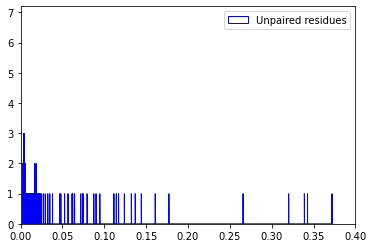

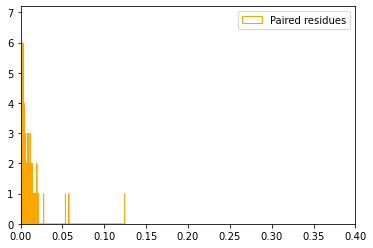

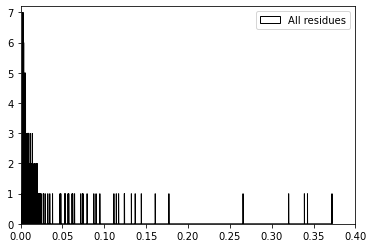

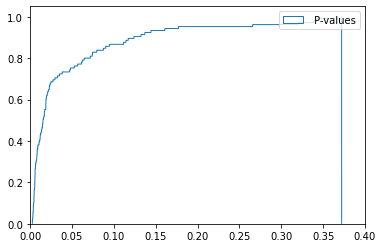

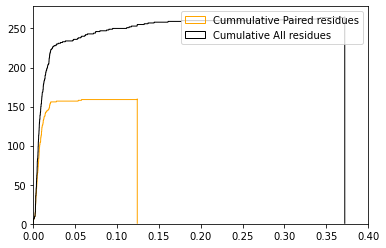

In [2]:
# P(r|U) P(r|P)
nbin = 10000
datu_h = plt.hist(datu, color="b", histtype="step", bins=nbin, label='Unpaired residues')
plt.ylim(0,7.2)
plt.xlim(0,0.40)
plt.legend()
plt.show()

datp_h = plt.hist(datp, color="orange", histtype="step", bins=nbin, label='Paired residues')
plt.legend()
plt.ylim(0,7.2)
plt.xlim(0,0.40)
plt.show()

dat_h  = plt.hist(dat, color="black", histtype="step", bins=nbin, label='All residues')
plt.legend()
plt.ylim(0,7.2)
plt.xlim(0,0.40)
plt.show()

# the CDF for datau is the p-value
datu_cdf, datu_bins, datu_patches = plt.hist(datu, density = True, cumulative=True, histtype="step", bins=nbin, label=" P-values")
plt.legend()
plt.xlim(0,0.40)
plt.show()

pval = datu_cdf

# cumulative count of reactivities for pair/all residues
datp_ucdf, datp_bins, datp_patches = plt.hist(datp, color="orange",density = 0, cumulative=True, histtype="step", bins=nbin, label='Cummulative Paired residues')
dat_ucdf,  dat_bins,  dat_patches  = plt.hist(dat,  color="black", density = 0, cumulative=True, histtype="step", bins=nbin, label='Cumulative All residues')
plt.legend()
plt.xlim(0,0.40)
plt.show()


r_target 0.0026 pval_target 0.0190 Found 25.0 [P 23.0 U 2.0 ] sen 14.37 exp FP 5.05 = [FDR 0.2019 x 25.0 ] [pval 0.0190 x 265 ]

r_target 0.0027 pval_target 0.0190 Found 25.0 [P 23.0 U 2.0 ] sen 14.37 exp FP 5.05 = [FDR 0.2019 x 25.0 ] [pval 0.0190 x 265 ]

r_target 0.0027 pval_target 0.0190 Found 28.0 [P 26.0 U 2.0 ] sen 16.25 exp FP 5.05 = [FDR 0.1803 x 28.0 ] [pval 0.0190 x 265 ]

r_target 0.0028 pval_target 0.0190 Found 29.0 [P 27.0 U 2.0 ] sen 16.88 exp FP 5.05 = [FDR 0.1741 x 29.0 ] [pval 0.0190 x 265 ]

r_target 0.0029 pval_target 0.0286 Found 36.0 [P 33.0 U 3.0 ] sen 20.62 exp FP 7.57 = [FDR 0.2103 x 36.0 ] [pval 0.0286 x 265 ]

r_target 0.0030 pval_target 0.0286 Found 36.0 [P 33.0 U 3.0 ] sen 20.62 exp FP 7.57 = [FDR 0.2103 x 36.0 ] [pval 0.0286 x 265 ]

r_target 0.0030 pval_target 0.0286 Found 36.0 [P 33.0 U 3.0 ] sen 20.62 exp FP 7.57 = [FDR 0.2103 x 36.0 ] [pval 0.0286 x 265 ]

r_target 0.0031 pval_target 0.0286 Found 37.0 [P 34.0 U 3.0 ] sen 21.25 exp FP 7.57 = [FDR 0.204

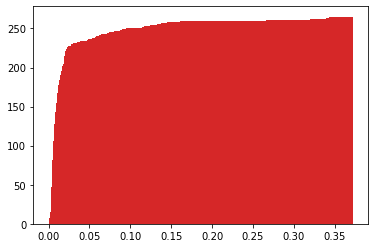

In [9]:
# Wednesday 28 Sep 2022
#
# P-value (r_target) = P(r < r_target | U)
#
nbin = 5000
pval, react, patches = plt.hist(datu, density = True, cumulative=True, bins=nbin, label=" P-values")

# Cumulative 
datp_cum, datp_bins, foo = plt.hist(datp, density = 0, cumulative=True, bins=nbin, label='Cummulative Paired residues')
datu_cum, datu_bins, foo = plt.hist(datu, density = 0, cumulative=True, bins=nbin, label='Cumulative All residues')
dat_cum,  dat_bins,  foo = plt.hist(dat,  density = 0, cumulative=True, bins=nbin, label='Cumulative All residues')

P = Np # P = The Trues (basepaired residues)

for i in range(nbin):
    # We use the P(r|U) as describing the null hypothesis
    pval_target = pval[i]
    r_target    = react[i]
    if r_target > 0.007:
        break
    
    #
    # r <= r_target are going to be assigned P
    # r >= r_target are going to be assigend U
    #
    
    # F = Found paired = total residues (out of N) with r <= r_target
    #
    for j in range(nbin):
        if dat_bins[j] <= r_target:
            F = dat_cum[j]      # F = Found
        if datp_bins[j] <= r_target:
            PF = datp_cum[j]    # PF = P and Found
        if datu_bins[j] <= r_target:
            UF = datu_cum[j]    # UF = U and Found
                
    # FP = expected false positives = 
    #    = expected from null to have r < r_target
    #
    FP  = pval_target*N    # expected false positives
    FDR = FP/F             # False Discovery Rate = 
                           #            fraction of FP per found
              
    sen = PF/P * 100  # sensitivity = True basepairs found with  r < r_target
        
        
    # print all those numbers
    #
    #  N = 265 = # total residues
    #  P = 160 = # paired residues 
    #  U = 105 = # unpaired residues 
    #
    # r_target  pval_target F(found) [#P #U]  sen(TP/T) exp_FP   FDR of F     pval of N          
        
    print("\nr_target", '{:.4f}'.format(r_target), "pval_target", '{:.4f}'.format(pval_target), "Found", 
          F, "[P", PF, "U", UF, "] sen", '{:.2f}'.format(sen), "exp FP", '{:.2f}'.format(FP), 
          "= [FDR", '{:.4f}'.format(FDR), "x", F, "] [pval", '{:.4f}'.format(pval_target), "x", N, "]")
        
